In [1]:
# helper functions for text cleanup, preprocessing and eature engineering
import helpers as h

contractions version: contractions 0.0.16
inflect version: inflect 0.3.1


In [2]:
import re, string, unicodedata
import os, glob, sys
import logging
from time import time
import datetime

import math
import numpy as np
np.random.seed(0) # set random seed for reproducibility
import pandas as pd
pd.set_option('display.width',4000)
pd.set_option('max_colwidth',4000)
pd.set_option('max_rows',100)
pd.set_option('max_columns',200)

import scipy as sp
import sklearn

import IPython
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivey = "all"
from IPython.display import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

# which versions
print("Python version: {}".format(sys.version))
print("NumPy version: {}".format(np.__version__))
print("pandas version: {}".format(pd.__version__))
print("seaborn version: {}".format(sns.__version__))
print("SciPy version: {}".format(sp.__version__))
print("scikit-learn version: {}".format(sklearn.__version__))
print("IPython version: {}".format(IPython.__version__))
print("matplotlib version: {}".format(matplotlib.__version__))

Python version: 3.5.5 | packaged by conda-forge | (default, Jul 24 2018, 01:52:17) [MSC v.1900 64 bit (AMD64)]
NumPy version: 1.13.1
pandas version: 0.20.3
seaborn version: 0.8.1
SciPy version: 0.19.1
scikit-learn version: 0.19.0
IPython version: 6.1.0
matplotlib version: 2.2.2


In [3]:
# additional smaller but useful libraries 
# contractions is capable of resolving contractions (and slang)
# could use to convert slang or create additional text
import contractions # expanding contractions here https://pypi.org/project/contractions/
print("contractions version: {}".format('contractions 0.0.16'))

# inflect.py - Correctly generate plurals, singular nouns, ordinals, indefinite articles; convert numbers to words.
# https://pypi.org/project/inflect/ 
import inflect # generating plurals, singular nouns, ordinals, indefinite articles, and converting numbers to words
print("inflect version: {}".format('inflect 0.3.1'))

contractions version: contractions 0.0.16
inflect version: inflect 0.3.1


In [4]:
import nltk
from nltk.corpus import stopwords

# custom tokenization for feature engineering using raw text
from nltk.tokenize import RegexpTokenizer

from nltk.tokenize import sent_tokenize # or can use
#from nltk.tokenize import PunktSentenceTokenizer # must be trained to be used
from nltk.tokenize import word_tokenize

from nltk.corpus import wordnet # for synonyms from WordNet

from nltk.stem import PorterStemmer # word stemming english words
from nltk.stem import SnowballStemmer # stemming non-English words
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer # another lemmatizer

from nltk.chunk import conlltags2tree, tree2conlltags # for nltk.Tree
from nltk import pos_tag
from nltk import ne_chunk
#from nltk.tag import StanfordPOSTagger  # another POS tagger

In [5]:
# scikit-learn nlp functionality
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
print('sklearn total stop words: {}'.format(len(ENGLISH_STOP_WORDS)))

from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
#from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.pipeline import make_pipeline

from sklearn.metrics import fbeta_score, accuracy_score

# model persistence
from sklearn.externals import joblib
# joblib.dump(clf, 'filename.pkl') 
# clf = joblib.load('filename.pkl')
# result = clf.score(X_test, y_test)
# yhat = clf.predict(X)

sklearn total stop words: 318


In [6]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
DATA_PATH = os.path.join(PROJECT_ROOT_DIR, "data")
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
MODEL_PATH = os.path.join(PROJECT_ROOT_DIR, "models")
TODAY = datetime.datetime.today().strftime('%Y-%m-%d')

# make sure all paths present
if not os.path.isdir(DATA_PATH):
    os.makedirs(DATA_PATH)
if not os.path.isdir(IMAGES_PATH):
    os.makedirs(IMAGES_PATH)
if not os.path.isdir(MODEL_PATH):
    os.makedirs(MODEL_PATH)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "_" + TODAY + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

def save_model(model, model_id, model_extension="pkl"):
    path = os.path.join(MODEL_PATH, model_id + "_" + TODAY + "." + model_extension)
    print("Saving model", model_id)
    joblib.dump(model, path) 

# test saving fig
#imdb_df.len.hist(bins=100)
#save_fig('test_save_img')
#plt.show()

In [10]:
path = os.path.join(DATA_PATH, "combined_raw_data*" + ".csv")
combined_data = glob.glob(path)
all_reviews = pd.read_csv(combined_data[0])

In [11]:
# create cleaned up, preprocessed tokens to be used by all three models. 
# %%timeit # 9.09 s ± 339 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# custom tokenization and preprocessing
# note: h.normalize revoves non-ascii words, converts to lower case, removes punct, 
#       replaces numbers with words, and removes stopwords
all_reviews['tokens'] = all_reviews["document"].apply(h.denoise_text) \
                                                .apply(h.replace_contractions) \
                                               .apply(nltk.word_tokenize) \
                                               .apply(h.normalize) \
                                               .apply(h.lemmatize_verbs)
all_reviews[['document','tokens']].head()

,document,tokens
0,"A very, very, very slow-moving, aimless movie about a distressed, drifting young man.","[slowmoving, aimless, movie, distress, drift, young, man]"
1,"Not sure who was more lost - the flat characters or the audience, nearly half of whom walked out.","[sure, lose, flat, character, audience, nearly, half, walk]"
2,"Attempting artiness with black & white and clever camera angles, the movie disappointed - became even more ridiculous - as the acting was poor and the plot and lines almost non-existent.","[attempt, artiness, black, white, clever, camera, angle, movie, disappoint, become, even, ridiculous, act, poor, plot, line, almost, nonexistent]"
3,Very little music or anything to speak of.,"[little, music, anything, speak]"
4,The best scene in the movie was when Gerardo is trying to find a song that keeps running through his head.,"[best, scene, movie, gerardo, try, find, song, keep, run, head]"


In [12]:
# then split between train/test
# looks like the data is split relatively evenly between classes [0,1]
# checking that stratify and shuffle are, in fact, the default
X_train, X_test, y_train, y_test = train_test_split(all_reviews['tokens'].apply(' '.join),
                                                    all_reviews['score'],
                                                    random_state=42, 
                                                    test_size=0.2
                                                   )
print('TRAINING:')
print('  length of X_train: {}\n'.format(len(X_train)))
print("  Samples per class (training):\n{}\n".format(y_train.value_counts()))

print('TESTING:')
print('  length of : {}\n'.format(len(X_test)))
print("  Samples per class (training):\n{}\n".format(y_test.value_counts()))

TRAINING:
  length of X_train: 2400

  Samples per class (training):
0    1207
1    1193
Name: score, dtype: int64

TESTING:
  length of : 600

  Samples per class (training):
1    307
0    293
Name: score, dtype: int64



In [13]:
# CountVectorizer tokenizes and creates the .vocabulary_
vect = CountVectorizer(max_features=10000, 
                       max_df=0.99,          # ignore terms w/ doc freq higher than threshold
                       min_df=0.01,          # ignore rarer terms
                       #stop_words="english", # using sklearn's stopwords
                       analyzer='char_wb',   # char level ngrams
                       ngram_range=(2, 10)     # using unigrams first
                      )
vect.fit(X_train)

CountVectorizer(analyzer='char_wb', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.99, max_features=10000, min_df=0.01,
        ngram_range=(2, 10), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [14]:
# inspect vocabulary
print('vocab size: {}:'.format(len(vect.vocabulary_)))
print('vocab:\n{}'.format(vect.vocabulary_)) # this is very large...

vocab size: 2523:
vocab:
{' be': 41, 'gra': 1251, ' work ': 595, ' better': 50, ' every': 158, 'ron': 2078, ' litt': 291, ' loo': 296, ' tw': 549, 'ak': 644, 'erfe': 1076, 'ine ': 1398, ' sup': 503, 'watch ': 2457, 'av': 745, 'uck': 2360, 'cter': 887, 'tabl': 2223, 'ittl': 1459, 'et ': 1120, 'pec': 1862, 'omme': 1746, ' would': 603, 'mov': 1612, ' ye': 607, 'serv': 2147, ' scre': 459, 'rrib': 2083, ' excelle': 169, ' come': 90, 'cellent ': 824, 'gh': 1234, 'rc': 1976, 'erythi': 1106, 'ation ': 737, 'ed': 995, 'terrible': 2257, ' compl': 97, 'abl': 612, 'eally ': 967, 'terrible ': 2258, 'oug': 1823, 'pric': 1934, 'old': 1731, 'rger': 2031, 'nitely ': 1674, 'xcellen': 2492, 'era': 1070, 'ny': 1706, 'plac': 1897, 'qui': 1959, 'cin': 848, 'oduct': 1719, ' del': 118, 'ye': 2506, 'bi': 787, ' d': 108, 'bri': 801, 'wr': 2485, 'harac': 1266, 'unc': 2380, 'rly ': 2064, 'ct ': 885, 'ke ': 1473, 'esp': 1113, 'mmen': 1605, 'pect ': 1867, 'py': 1950, 'fect': 1173, ' happ': 239, 'rd': 1977, 'come': 

In [15]:
# create BOWs representation of data by tranformming
# and storing in a dense representation of stem_BOWs
BOCs_train = vect.transform(X_train)
print('bag of words:\n{}'.format(BOCs_train.toarray()))

bag of words:
[[0 0 0 ..., 0 0 0]
 [1 0 1 ..., 0 0 0]
 [1 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 0 0]
 [1 1 0 ..., 0 0 0]]


In [16]:
feature_names = vect.get_feature_names()
print('num features: {}\n'.format(len(feature_names)))
print('features head: {}\n'.format(feature_names[:5]))
print('every 100th feature:\n{}\n'.format(feature_names[::100]))
print('features tail: {}'.format(feature_names[-5:]))

num features: 2523

features head: [' a', ' ab', ' ac', ' act', ' act ']

every 100th feature:
[' a', ' cont', ' foo', ' love', ' pretty ', ' str', ' worth', 'aracter ', 'break', 'day', 'eed', 'ervice', 'five ', 'hone ', 'ing ', 'lem', 'minute', 'nty', 'ort', 'play', 'recommend', 'ru', 'ste', 'tiv', 'usa', 'xperien']

features tail: ['ythin', 'ything', 'ything ', 'ze', 'ze ']


In [17]:
scores = cross_val_score(LogisticRegression(random_state=42), 
                         BOCs_train, # from X_train 
                         y_train, 
                         cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.77


In [18]:
# look at the range of model scores
scores

array([ 0.79417879,  0.77338877,  0.76875   ,  0.76617954,  0.76409186])

### INSPECT MODEL - DATA VISUALIZATION


* visualize the top coefficients from the sklearn model
  * Looking at the top/bottom weightings helps to make sense and build and intuition of how the model works, which in turn completes the Qualitative aspect of measuring whether the algo is working as expected (i.e. that the patterns discovered have value and aren't lucky for the data).
  * Please note: the visualization for important features (top n features) was inspired from workshops attended and books read from Andreas Mueller, PhD. 

* The confusion matrix makes sense as well and demonstrates that the model is working, as advertized in the cross validation step of training and validating.
  * The character-level model is astounding. I varied the number of character-grams between 2-15, with and without stopwords, and raw text/preprocessed text. The models' performance were consistently between 75-83% accuracy. I got the idea reading a paper on text generation using NNs and character sequences from trained text like Shaekespeare and stackoverflow.com.

In [19]:
feature_names = vect.get_feature_names()
print('num features: {}\n'.format(len(feature_names)))
print('features head: {}\n'.format(feature_names[:5]))
print('every 100th feature:\n{}\n'.format(feature_names[::100]))
print('features tail: {}'.format(feature_names[-5:]))

num features: 2523

features head: [' a', ' ab', ' ac', ' act', ' act ']

every 100th feature:
[' a', ' cont', ' foo', ' love', ' pretty ', ' str', ' worth', 'aracter ', 'break', 'day', 'eed', 'ervice', 'five ', 'hone ', 'ing ', 'lem', 'minute', 'nty', 'ort', 'play', 'recommend', 'ru', 'ste', 'tiv', 'usa', 'xperien']

features tail: ['ythin', 'ything', 'ything ', 'ze', 'ze ']


In [20]:
# get the feature names
feature_names = np.array(vect.get_feature_names())
# find the max for each feature
max_val = BOCs_train.max(axis=0).toarray().ravel()
# sort the index
sorted_coef_index = max_val.argsort()
print('smallest coefficients/close to 0:\n{}\n'.format(feature_names[sorted_coef_index[:40]]))
print('largest coefficients/close to 1:\n{}'.format(feature_names[sorted_coef_index[:-41:-1]]))

smallest coefficients/close to 0:
['hand' 'ces' 'people ' 'people' 'peopl' 'peop' 'peo' 'pen' 'pect ' 'pect'
 'pecial' 'pecia' 'peci' 'pec' 'perf' 'cho' 'cin' 'pan' 'cle' 'comme'
 'commen' 'commend' 'commend ' 'comp' 'compl' 'ousand' 'cons' 'ousan' 'coo'
 'cial' 'perfe' 'cene' 'perfec' 'por' 'poor ' 'bea' 'beli' 'belie' 'ple '
 'ple']

largest coefficients/close to 1:
['y ' 'e ' ' s' 'er' ' su' 'ck' 'k ' 'uck ' 'uc' 'ck ' 'uck' 'n ' 'an' 'ar'
 'su' 'l ' 'ch' 'al' 'd ' 'ca' ' c' 's ' ' m' 't ' 'se' ' t' 'on' 'el' 'r '
 'ne' 'he' 'h ' ' e' 'en' 'nd' 'ce' 'oo' 'ma' 'p ' ' a']


In [21]:
lr_clf = LogisticRegression(random_state=42)
lr_clf.fit(BOCs_train, y_train)
BOCs_test = vect.transform(X_test)
predictions = lr_clf.predict(BOCs_test)

Saving figure bocs_top_40_features


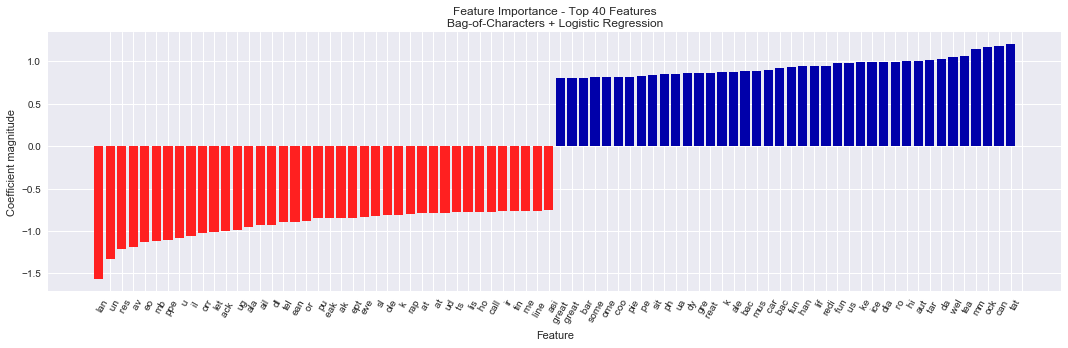

In [22]:
# viz of the top coefficients for the 
h.visualize_coefficients(coefficients=lr_clf.coef_,
                         feature_names=feature_names, 
                         n_top_features=40)
plt.title('Feature Importance - Top 40 Features\nBag-of-Characters + Logistic Regression')
save_fig("bocs_top_40_features")

Saving figure bocs_confusion_matrix


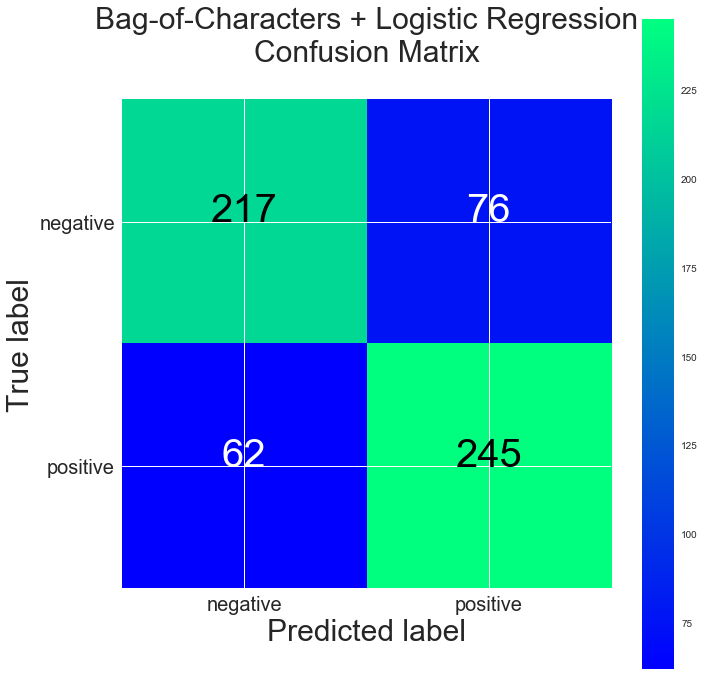

In [23]:
# create a confusion matrix
conf_matrix = h.confusion_matrix(y_test, predictions)

# plot the confusion matrix
fig = plt.figure(figsize=(10,10))
h.plot_confusion_matrix(conf_matrix,
                        classes=['negative','positive'], 
                        normalize=False, 
                        title='Bag-of-Characters + Logistic Regression\nConfusion Matrix\n')

save_fig("bocs_confusion_matrix",tight_layout=False)

In [24]:
# unpack metrics using function
accuracy, precision, recall, f1 = h.get_metrics(y_test, predictions)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.770, precision = 0.770, recall = 0.770, f1 = 0.770


In [25]:
# save models (CountVectorizer and Logistic Regression)
save_model(vect,'bocs')
save_model(lr_clf,'logistic_regression_w_bocs')

Saving model bocs
Saving model logistic_regression_w_bocs


## GridSearch for Best Model
----- 
* Let's see how competitive this model can be!
* holding maximum geatures to 10000 for comparative purposes
* we will explore n-gram ranges and regularization constant C
* exploring variety of range for character n-grams
* exploring min and max document frequency of character n-gram

In [26]:
# use sklearn's pipeline functionality
# leaving out stopwords, keeping C range close to what has been working (1)
pipe = make_pipeline(CountVectorizer(max_features=10000, 
                                     analyzer='char_wb',   # char level ngrams
                                    ), 
                     LogisticRegression(random_state=42)
                    )

# grid and the inclusion of trigrams
param_grid = {"countvectorizer__ngram_range": [(2,3), (2, 5), (2,10)],
              "countvectorizer__min_df": [0.01, 0.05], # removing this b/c pruning removes all features
              "countvectorizer__max_df": [0.80, 0.90, 0.99]
              #"logisticregression__C": [0.1, 1]
             }

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.77
Best parameters:
{'countvectorizer__max_df': 0.8, 'countvectorizer__ngram_range': (2, 10), 'countvectorizer__min_df': 0.01}


In [82]:
grid_results = pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score', ascending=True)
#display(grid_results.info())
keep_cols = ['mean_test_score', 'mean_train_score', 'param_countvectorizer__max_df', 
             'param_countvectorizer__min_df', 'param_countvectorizer__ngram_range', 
             'params', 'rank_test_score', 'std_test_score', 'std_train_score']
#display(grid_results[keep_cols])
#display(grid_results[['mean_test_score',
#                      'param_countvectorizer__ngram_range',
#                      'param_countvectorizer__max_df', 
#                      'param_countvectorizer__min_df']])
#grid.cv_results_['mean_test_score'].reshape(-1, 3).T

In [69]:
piv = pd.pivot_table(data=grid_results[['mean_test_score',
                                  'param_countvectorizer__ngram_range',
                                  'param_countvectorizer__max_df',
                                  'param_countvectorizer__min_df']], 
               index=['param_countvectorizer__min_df','param_countvectorizer__max_df'], 
               columns='param_countvectorizer__ngram_range',
               values='mean_test_score').T
piv

param_countvectorizer__min_df           0.01                          0.05                    
param_countvectorizer__max_df           0.80      0.90      0.99      0.80      0.90      0.99
param_countvectorizer__ngram_range                                                            
(2, 3)                              0.760000  0.760000  0.760000  0.724583  0.724583  0.724583
(2, 5)                              0.768750  0.768750  0.768750  0.727917  0.727917  0.727917
(2, 10)                             0.770833  0.770833  0.770833  0.727917  0.727917  0.727917

Saving figure logistic_regression_BoCs_gridsearch


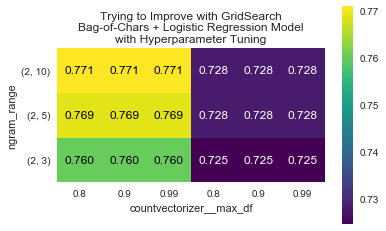

In [81]:
# extract scores from grid_search
scores = piv #grid.cv_results_['mean_test_score'].reshape(-1, 3).T
# visualize heatmap
heatmap = h.heatmap(scores, 
                    xlabel='countvectorizer__max_df', 
                    ylabel="ngram_range", 
                    cmap="viridis", 
                    fmt="%.3f",
                    xticklabels=2* param_grid['countvectorizer__max_df'],
                    yticklabels=param_grid['countvectorizer__ngram_range'])

plt.colorbar(heatmap)
plt.title('Trying to Improve with GridSearch\nBag-of-Chars + Logistic Regression Model\nwith Hyperparameter Tuning')
save_fig("logistic_regression_BoCs_gridsearch",tight_layout=False)
plt.show()

Saving figure logistic_regression_tfidf_gridsearch_best_estimator_top_30_features


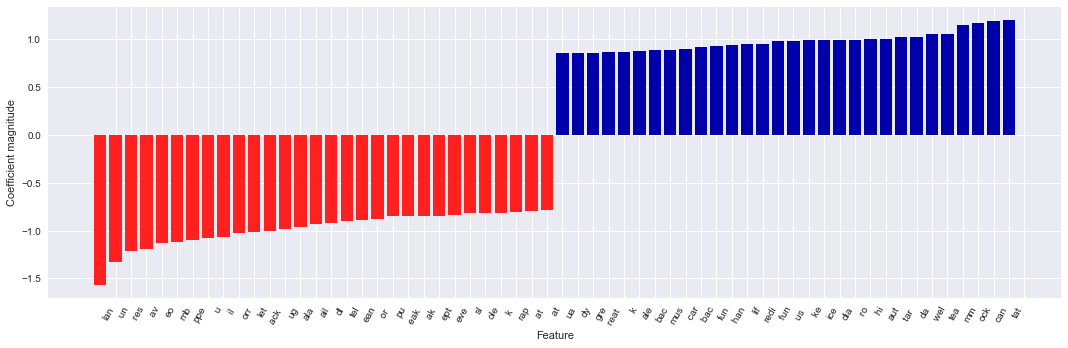

In [30]:
# extract feature names and coefficients
vect = grid.best_estimator_.named_steps['countvectorizer']
feature_names = np.array(vect.get_feature_names())
coef = grid.best_estimator_.named_steps['logisticregression'].coef_
h.visualize_coefficients(coef, 
                         feature_names, 
                         n_top_features=30)

save_fig("logistic_regression_tfidf_gridsearch_best_estimator_top_30_features")

In [32]:
# save the model
save_model(grid.best_estimator_.named_steps['countvectorizer'], 'logistic_regression_w_chars_best_vect')
save_model(grid.best_estimator_.named_steps['logisticregression'], 'logistic_regression_w_chars_best_model')

Saving model logistic_regression_w_chars_best_vect
Saving model logistic_regression_w_chars_best_model


## Let's examine mistakes by Character-Level Model

In [83]:
# let's look at the incorrect predictions
# add the predictions of default BoWs to the all_reviews dataframe
# https://stackoverflow.com/questions/45176469/can-i-get-a-list-of-wrong-predictions-in-svm-score-function-in-scikit-learn?rq=1
#print(all_reviews['y_pred_def_bows'].count())
#all_reviews['y_pred_def_bows'] = lr_clf.predict(vect.transform(all['reviews'].astype(str)))
X_BoC = grid.best_estimator_.named_steps['countvectorizer'].transform(all_reviews['tokens'].apply(' '.join).as_matrix())
y_pred_def_boc = lr_clf.predict(X_BoC)
y_pred_prob_def_boc = lr_clf.predict_proba(X_BoC)

# predict over whole group with the model and compare to actual target
all_reviews['y_pred_def_boc'] = y_pred_def_boc
# predict probabilities to compare how close, confident the prediction was
all_reviews['y_pred_prob_def_boc_0'] = y_pred_prob_def_boc[:,0]
all_reviews['y_pred_prob_def_boc_1'] = y_pred_prob_def_boc[:,1]

In [84]:
mistakes = all_reviews['score'] != all_reviews['y_pred_def_boc']
# observations: mistakes are consistently made with positive sentiment
# imdb had ~45-50% more errors, which could likely change over a larger dataset and more training
g = all_reviews[mistakes].groupby(['source','score'])['source'].size() / 500 #.plot(kind='bar')
g = pd.DataFrame(g).rename(columns={'source':'mistakes_pct'}).reset_index()
g

,source,score,mistakes_pct
0,amazon,0,0.088
1,amazon,1,0.080
2,imdb,0,0.096
3,imdb,1,0.090
4,yelp,0,0.082
5,yelp,1,0.084


Saving figure bowc_default_top_30_features_mistakes


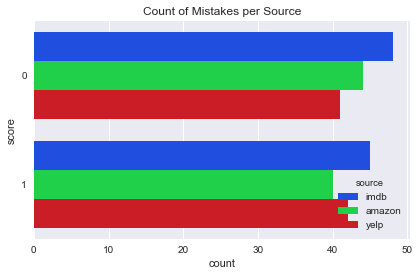

In [86]:
# plot the mistakes
ax = sns.countplot(y='score', 
                   hue='source', 
                   data=all_reviews[['source','score']][mistakes], 
                   palette='bright')
plt.title('Count of Mistakes per Source')
save_fig("bowc_default_top_30_features_mistakes")
plt.show()

## Test Sentences from, urbandictionary.com
-----
The idea is to grab and label polarized sentences from yet another source. This will help demonstrate if the model is generalizing well, investigate any shortcomings/look for inspiration for ideas of improvement.

In summary, these work pretty well. The ones that were missed, would be challenging even as a human, without more context like speaker's disposition/bias, or word intention/meanings. 

Also, using a strategy of the two highest probabilites per class would do quite nicely. An example is Index 2 "Nah, that place is a total touristaurant, my food was awful last time I ate there." where Bag-of-Words choked but the other two models were within the top quartile of predicting negative sentiment.

In [33]:
# document & score
contrived_sents = [("Expensive restaurants with horrible food that people still go to for the prime location or atmosphere.", 0), 
 ("It has a beautiful view of the Eiffel Tower!", 1),
 ("Nah, that place is a total touristaurant, my food was awful last time I ate there.", 0),
 ("I had a great day, climbed a hill and didn't check facebook.", 1),
 ("That corgi-shaped macaron is expensive because it's got instagram tax.", 0),
 ("That 1962 Alfa Romeo is good for transportainment", 1),
 ("not so great for getting to work in the snow", 0),
 ("This is so sad Alexa play despacito", 0),
 ("This better not escalate to Dutch ovens any time soon...", 0),
 ("Oh. It has too many calories for me. Well, OK.", 1),
 ("Mmm, this pizza is some good food.", 1),
 ("Food's better for throwing at someone than eating.", 0), 
 ("Are you finished with your restau-rant? I get it, we're outta here. Let's pay the check and leave.", 0),
 ("The Primrose Bar and Restaurant in Ballynahinch, Co. Down in the north of Ireland is one of the best in the country. ",  1),
 ("This burger is crappy.", 0),
 ("DUDE! I got buffungled by Amazon.com with a 8-12 day shipping time!", 0),
 ("I am going to <b>BUY</b> that game RIGHT NOW.", 1),
 ("wow, that was great!", 1),
 ("That movie was great!", 1),
 ("The computer crashed again. I lost three thousand lines of code.", 0)
]

df_contrived = pd.DataFrame(contrived_sents,columns=['document','score'])
df_contrived.head()

,document,score
0,Expensive restaurants with horrible food that people still go to for the prime location or atmosphere.,0
1,It has a beautiful view of the Eiffel Tower!,1
2,"Nah, that place is a total touristaurant, my food was awful last time I ate there.",0
3,"I had a great day, climbed a hill and didn't check facebook.",1
4,That corgi-shaped macaron is expensive because it's got instagram tax.,0


In [34]:
df_contrived['tokens'] = df_contrived['document'].apply(h.denoise_text) \
                                                 .apply(h.replace_contractions) \
                                                 .apply(nltk.word_tokenize) \
                                                 .apply(h.normalize) \
                                                 .apply(h.lemmatize_verbs)
BOCs_urban_dict = vect.transform(df_contrived['tokens'].apply(' '.join).tolist())
urban_preds = lr_clf.predict(BOCs_urban_dict)
df_contrived['prediction'] = urban_preds

In [35]:
df_contrived

,document,score,tokens,prediction
0,Expensive restaurants with horrible food that people still go to for the prime location or atmosphere.,0,"[expensive, restaurants, horrible, food, people, still, go, prime, location, atmosphere]",0
1,It has a beautiful view of the Eiffel Tower!,1,"[beautiful, view, eiffel, tower]",1
2,"Nah, that place is a total touristaurant, my food was awful last time I ate there.",0,"[nah, place, total, touristaurant, food, awful, last, time, eat]",0
3,"I had a great day, climbed a hill and didn't check facebook.",1,"[great, day, climb, hill, check, facebook]",1
4,That corgi-shaped macaron is expensive because it's got instagram tax.,0,"[corgishaped, macaron, expensive, get, instagram, tax]",1
5,That 1962 Alfa Romeo is good for transportainment,1,"[one thousand, nine hundred and sixty-two, alfa, romeo, good, transportainment]",1
6,not so great for getting to work in the snow,0,"[great, get, work, snow]",1
7,This is so sad Alexa play despacito,0,"[sad, alexa, play, despacito]",1
8,This better not escalate to Dutch ovens any time soon...,0,"[better, escalate, dutch, ovens, time, soon]",1
9,"Oh. It has too many calories for me. Well, OK.",1,"[oh, many, calories, well, ok]",0


In [36]:
df_contrived[df_contrived['prediction'] != df_contrived['score']]

,document,score,tokens,prediction
4,That corgi-shaped macaron is expensive because it's got instagram tax.,0,"[corgishaped, macaron, expensive, get, instagram, tax]",1
6,not so great for getting to work in the snow,0,"[great, get, work, snow]",1
7,This is so sad Alexa play despacito,0,"[sad, alexa, play, despacito]",1
8,This better not escalate to Dutch ovens any time soon...,0,"[better, escalate, dutch, ovens, time, soon]",1
9,"Oh. It has too many calories for me. Well, OK.",1,"[oh, many, calories, well, ok]",0
12,"Are you finished with your restau-rant? I get it, we're outta here. Let's pay the check and leave.",0,"[finish, restaurant, get, outta, let, us, pay, check, leave]",1
13,"The Primrose Bar and Restaurant in Ballynahinch, Co. Down in the north of Ireland is one of the best in the country.",1,"[primrose, bar, restaurant, ballynahinch, co, north, ireland, one, best, country]",0


### Summary - Bag-of-Characters
-----
Bag-of-Characters was a surprise performer. The best performing model was with the ngram_range of (2, 10), a documet frequency min/max of 0.01/0.80. Given the scores, this would be a contender for a generalized model offering.